# Linear Transformation 
We will start with the alignement of the same models for different seeds. 
- First we do not restrict the matrix.
- Second we restrict the matrix to be a rotation matrix.
- Thrid use affine transformation 
- Last but not least we are using different norms and regularization techniques to improve the results



Steps: 
- Load the same model but with different seed
- Sample different images and get latent representation 
- Create Datamatrix X and X'
- Solve the simple optimization problem


In [2]:
# Import relevant libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from sklearn.decomposition import PCA


In [3]:
# Configuration

config = {
    'path1': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_1_10.pth",
    'modelname1': 'VAE1',
    'path2': "/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/VAE/models/MNIST_VAE_2_10.pth",
    'modelname2': 'VAE2',

}

# Optimization Problem in the Linear Case 
Let $x^i,y^i \in \mathbb{R^n}$ for $i = 1,...,m$ and $A \in \mathbb{R}^{n \times n}$ we are looking for the optimal A, which solves the following optimization problem 
$$ min_A \sum_{i = 1}^n ||Ax^i - y^i||^2 $$
where we are using the euclidian norm when not otherwise stated.



## Load Model and Transformed Data for VAE

In [4]:
# get working directory
import os
# Change directory
os.chdir('/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication')

# Import Data 
from helper.DataLoaderMNIST import DataLoader_MNIST

# Transdormations
transformations = [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]
# Load the data
data_loader = DataLoader_MNIST(128, transformations)

from VAE.model_def import VAE
DEVICE = torch.device('mps')

# Initialize the models
model = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)

# Load pretrained weights for model1
model.load_state_dict(torch.load(config['path1']))

# Initialize the model 2
model2 = VAE(in_dim=784, dims=[256, 128, 64, 32], distribution_dim=16).to(DEVICE)
# Load pretrained weights for model2
model2.load_state_dict(torch.load(config['path2']))




<All keys matched successfully>

## Sampling 
We sample images from the train set and encode those for each model 

In [5]:
# Simple Sampler which takes random points from the train set

def sampler(m,model1, model2): 
    images, _ = next(iter(data_loader.train_loader))
    all_images = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        all_images.append(images)
        all_labels.append(labels)
    # Concatenate all the batches to form a single tensor for images and labels
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
     # Sample indices from the train set
    indices = np.random.choice(all_images.shape[0], m, replace=False)

    all_images_sample = all_images[indices]
    all_labels_sample = all_labels[indices]
    

    z1 = model1.getLatenSpace(all_images_sample.to(DEVICE))
    z2 = model2.getLatenSpace(all_images_sample.to(DEVICE))

    # Detach from GPU
    z1 = z1.detach().cpu().numpy()
    z2 = z2.detach().cpu().numpy()  

    return z1, z2, all_images_sample, all_labels_sample

z1, z2, images, labels = sampler(200, model, model2)


# Samples from every class
def sampler_sufficient(m,model1,model2):
    images, _ = next(iter(data_loader.train_loader))
    all_images = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        all_images.append(images)
        all_labels.append(labels)
    # Concatenate all the batches to form a single tensor for images and labels
    all_images = torch.cat(all_images, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Distinct labels
    labels = torch.unique(all_labels)
    # Sample size per label
    m_per_label = m // len(labels)
    # Sample from each label
    indices = []
    for label in labels:
        indices_label = np.where(all_labels == label)[0]
        indices_label = np.random.choice(indices_label, m_per_label, replace=False)
        indices.extend(indices_label)
    
    all_images_sample = all_images[indices]
    # Get latent space 
    z1 = model1.getLatenSpace(all_images_sample.to(DEVICE))
    z2 = model2.getLatenSpace(all_images_sample.to(DEVICE))

    # Detach from GPU
    z1 = z1.detach().cpu().numpy()
    z2 = z2.detach().cpu().numpy()

    return z1, z2, all_images_sample

z1_suf, z2_suf, images_suf = sampler_sufficient(200, model, model2)



print(z1)



 

[[2.7273946  3.7393587  0.         ... 0.         3.2014835  2.1367338 ]
 [2.6361117  2.6102045  0.         ... 2.1707618  5.9980683  3.0741584 ]
 [4.0545845  3.650984   0.         ... 0.02136472 2.608537   2.5455244 ]
 ...
 [3.888913   3.7964368  0.         ... 0.723221   1.801805   3.2549434 ]
 [4.5628242  4.3083377  0.         ... 0.         2.6266692  4.524952  ]
 [3.03214    4.1962824  0.         ... 1.7946277  5.986553   3.4416463 ]]


In [6]:
z1.shape

(200, 32)

In [7]:
z1[0]

array([2.7273946 , 3.7393587 , 0.        , 4.6143274 , 5.31439   ,
       2.8250115 , 2.1850903 , 1.9736366 , 2.5393605 , 4.75917   ,
       3.0970936 , 1.6740435 , 0.        , 0.        , 3.88933   ,
       0.        , 0.        , 4.2714324 , 3.0012586 , 0.9995406 ,
       2.3147688 , 3.1804576 , 0.        , 3.834889  , 2.8843617 ,
       2.2079744 , 3.5477169 , 0.44094372, 0.        , 0.        ,
       3.2014835 , 2.1367338 ], dtype=float32)

In [16]:
z1[0]

array([2.7273946 , 3.7393587 , 0.        , 4.6143274 , 5.31439   ,
       2.8250115 , 2.1850903 , 1.9736366 , 2.5393605 , 4.75917   ,
       3.0970936 , 1.6740435 , 0.        , 0.        , 3.88933   ,
       0.        , 0.        , 4.2714324 , 3.0012586 , 0.9995406 ,
       2.3147688 , 3.1804576 , 0.        , 3.834889  , 2.8843617 ,
       2.2079744 , 3.5477169 , 0.44094372, 0.        , 0.        ,
       3.2014835 , 2.1367338 ], dtype=float32)

In [19]:
z1[0,0]*z1[0,0]

7.438681

In [17]:
np.outer(z1[0], z1[0])

array([[ 7.438681 , 10.198707 ,  0.       , ...,  0.       ,  8.731709 ,
         5.827716 ],
       [10.198707 , 13.982803 ,  0.       , ...,  0.       , 11.971495 ,
         7.990014 ],
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       ...,
       [ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 8.731709 , 11.971495 ,  0.       , ...,  0.       , 10.249496 ,
         6.840718 ],
       [ 5.827716 ,  7.990014 ,  0.       , ...,  0.       ,  6.840718 ,
         4.5656314]], dtype=float32)

# Calulate optimal matrix 
To ensure invertibility we using as regularization the Matrix in the Frobeniusnorm with lamda as regularization parameter

In [20]:
# Calculates the optimal matrix with abritray regularization (Frobenius normm)
def optimalMatrix(z1,z2,lamda = 0.01):
    # Get the dimensions of the latent space
    d = z1.shape[1]

    # Initalize the matrices
    M = np.zeros((d, d))
    L = np.zeros((d, d))

    # Compute the matrices
    for i in range(d):
        M = M + np.outer(z1[i], z1[i])
        L = L + np.outer(z1[i], z2[i])

    # COmpute the optimal regularized matrix
    A = L @ np.linalg.inv(M + lamda * np.eye(d)) 

    return A

A = optimalMatrix(z1,z2, )
A_suf = optimalMatrix(z1_suf,z2_suf)

print(A.shape)
print(A_suf.shape)


print(A_suf)




(32, 32)
(32, 32)
[[-11496.73235211   6294.76216994      0.         ...   2472.31840278
    3805.74331883   9093.84965152]
 [-11726.15171704   6771.96159655      0.         ...   2045.48629465
    3314.06610493  10036.79546327]
 [     0.              0.              0.         ...      0.
       0.              0.        ]
 ...
 [ -3466.29056104   2097.76405981      0.         ...    824.29624485
    1471.2223137    2124.48769094]
 [-11199.79775413   7387.23319684      0.         ...   3314.72616696
    3623.00321922   7875.2586259 ]
 [-10115.08445952   5889.66639921      0.         ...   1912.15222425
    3573.07998992   7765.03648824]]


# Distance regarding the sample size 

In [21]:
def transformedDistances(z1, z2, A):
    # Compute the transformed distances
    distances = np.zeros(z1.shape[0])
    for i in range(z1.shape[0]):
        distances[i] = np.linalg.norm(A @ z1[i] - z2[i])

    return distances


distances = transformedDistances(z1, z2, A)
distances_suf = transformedDistances(z1_suf, z2_suf, A_suf)
print(distances.shape)
print(distances_suf.shape)

distances_non = transformedDistances(z1, z2,np.eye(32) )


# Plot the distances
print('Mean Distance:', np.mean(distances))
print('Mean Distance Sufficient:', np.mean(distances_suf))
print('Mean Distance Non:', np.mean(distances_non))



(200,)
(200,)
Mean Distance: 7176.344627413291
Mean Distance Sufficient: 7570.508697796804
Mean Distance Non: 15.401825400383228


# Alignement of Transformed Latent Vectors 

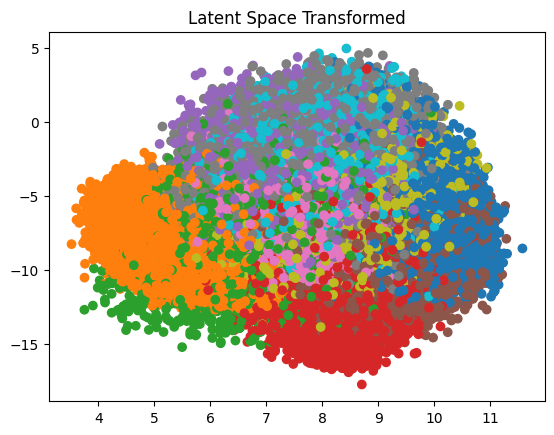

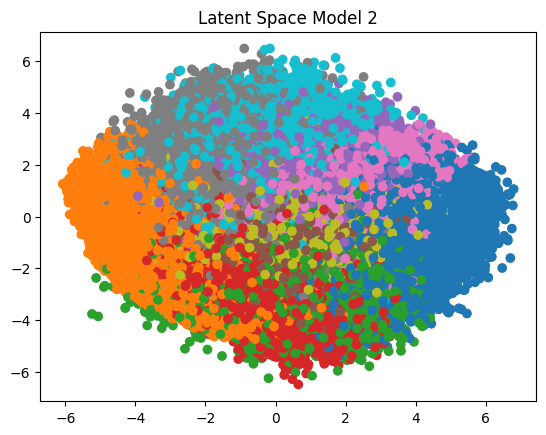

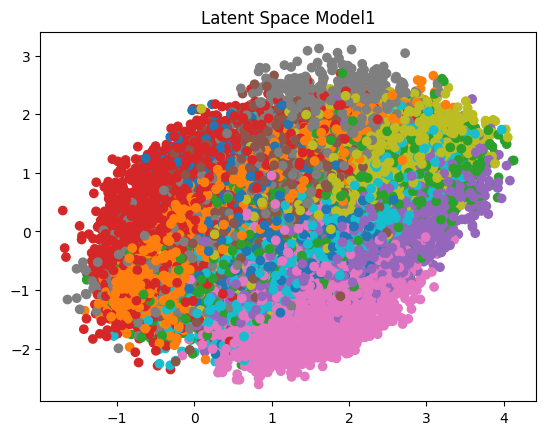

In [46]:
def pca_def(v):
    pca = PCA(n_components=2)
    pca.fit(v)
    return pca


def plotLatentTransformed(model, A, pca1, name):
    images, _ = next(iter(data_loader.train_loader))
    latent_spaces = []
    all_labels = []
    for images, labels in data_loader.train_loader:
        images = images.to(DEVICE)
        images = images.view(images.size(0), -1)
        latent_space = model.getLatenSpace(images)
        latent_space = latent_space.cpu().detach().numpy()
        latent_spaces.append(latent_space)
        all_labels.append(labels.numpy())

    # Concatenate latent space representations from all batches
    latent_space = np.concatenate(latent_spaces, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Transform the latent space
    latent_space_transformed = np.dot(latent_space, A.T)
    # Plot latent space via PCA
    latent_space_pca = pca1.transform(latent_space_transformed)

    # Plot the latent space

 
    plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
    plt.title('Latent Space '+ name)
    plt.show(plot)


    return  plot

I = np.eye(32)

pca1 = pca_def(z2)



plotLatentTransformed(model, A, pca1, 'Transformed')
plotLatentTransformed(model2, I, pca1, 'Model 2')
plotLatentTransformed(model, I, pca1, 'Model1')

# PCA die gleich PCA die unterschiedlich 
# Sample from different classes 
# Ähnliche Werte 




In [ ]:
# Latent vector for specific samples 

